# Graham Dominick
## Data Science Final Project
### https://github.com/Graham-Dom/CSPB-3022-FinalProject

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Motivation:

## I've always been interested in sports, particularly NBA basketball. NBA teams have recently started taking advantage of statistical methods to improve performance, or play more efficiently. This has really changed the way the game is played, and has lead to entirely new offensive strategies. 

## For my final project I will be doing some of my own statistical analysis on NBA teams, asking, what what factors lead to winning records in the regular season. I have downloaded a dataset from https://data.world/gmoney/nba-team-records-by-year that specifies the win percentage of every NBA team from every season since 1950 (1417 records total).

In [2]:
win_loss = pd.read_csv("win_loss_data.csv", usecols=[0,1,2,3])
display(win_loss.iloc[np.random.choice(len(win_loss), 5)])

,Year,Team,Record,Winning Percentage
757,2011-12 *,Heat,46-20,0.697
511,1957-58,Warriors,37-35,0.514
900,1989-90,Knicks,45-37,0.549
497,1971-72,Warriors,51-31,0.622
1388,1989-90,Bullets,31-51,0.378


## NBA basketball is arguably the quintessential "superstar" sport. Stars in basketball can make an impact on their teams success unlike star players in any of the other main American professional sports (football, hockey, baseball). Just look at the dropoff in win percentage when Lebron James left the Cleveland Cavaliers for the Miami Heat in 2010.

In [3]:
print(win_loss.iloc[[267, 266, 265, 264, 263, 262]])

          Year       Team Record  Winning Percentage
267    2007-08  Cavaliers  45-37               0.549
266    2008-09  Cavaliers  66-16               0.805
265    2009-10  Cavaliers  61-21               0.744
264    2010-11  Cavaliers  19-63               0.232
263  2011-12 *  Cavaliers  21-45               0.318
262    2012-13  Cavaliers  24-58               0.293


## Because of this, I want to correlate individual player statistics to a team's winning percentage, and determine which individual metrics best predict team success.

# Goals for this Project

## 1. Generate as accurate as possible a model for the win % of an NBA team for 1990-2017 based on player statistics.

## 2. Examine model residual scores against year to determine if the model is consistently accurate over time.


## I will be combining two datasets for this project. I described the team statistics dataset above.

## For player statistics I will be using a dataset of statistics for ~3900 different players, and ~23000 different seasons which also goes back to 1950 from Kaggle. https://www.kaggle.com/drgilermo/nba-players-stats/data 

In [4]:
player_stats = pd.read_csv("season_stats.csv")
print(player_stats.columns)

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')


## This dataset contains lots of statistics on players, ranging from simple ones, like minutes played or points scored, to more complex statistics like true shooting percentace (TS%), player efficiency rating (PER), win shares, box plus/minus, and value over replacement player (VORP).

In [5]:
display(player_stats.columns)

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## I'll explain some of these complex metrics later on, but for now, let's trim down this dataset by dropping some columns that we don't need.

#### We can drop games played (G) and games started (GS) in favor of minutes played (MP), a more precise measure of playing time.
#### Stats like assist % (AST%), rebound % ( ORB%, DRB%, TRB%), usage % (USG%), are factored into the advanced metrics (BPM and PER), so we can use those instead
#### The shooting percentage stats (3P%, 2P%, eFG%, FT%, etc.) are encapsulated by true shooting percentage (TS%) so we can also drop those.
#### Win shares are a measure of how much a player contributued to a team's win. So a player's win shares are directly propotional to the number of wins by their team. We want to focus on purely individual statistics, so we can throw that out.

In [6]:
player_stats.drop(columns=['Unnamed: 0', 'Pos', 'G', 'GS', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 
                           'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'blanl', 'DWS', 'blank2',
                           'OBPM', 'DBPM', 'FG', 'FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 
                           'eFG%', 'FTA', 'ORB', 'DRB', 'WS', 'WS/48'], inplace=True)

## Here are the columns we're left with. The player's names aren't necessary for analysis, but are helpful metadata, especially for making sure the cleaning process goes right, and for providing anecdotal analysis. "GA-SW" stands for offensive win shares, and was unable to be dropped from the table due to the hyphen in the name.

## Year and Team will be used as categorical variables to match a player's statistics to a specific team and season. The remaining 17 columns are numerical and will be used for modeling. 

##  12 of these fields are discrete: Age, MP, 3P, 2P, FT, TRB, AST, STL, BLK, TOV, PF, and PTS, and the remaining 5 are continuous: PER, TS%, BPM, VORP, FT%.

In [7]:
display(player_stats.columns)

Index(['Year', 'Player', 'Age', 'Tm', 'MP', 'PER', 'TS%', 'OWS', 'BPM', 'VORP',
       '3P', '2P', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS'],
      dtype='object')

## For the team statistics dataset, the only columns that we care about are the team and year, for matching up with players, and the winning percentage.

# =============================================================

## First, we need to join the datasets in a way that makes sense for the analysis we want to do. For each team/season, I'm going to add statistics for the top 5 players per team, based on number of minutes played that season. To do, that, we first need to do some serious cleaning and reformatting...

# Cleaning and Reformatting

## There are some blank rows in the players dataset that make it prettier in spreadsheet form. Let's get rid of those rows

In [8]:
player_stats.dropna(subset=["Year", "Player"], inplace=True)

## The year for two of the Knicks' seasons were entered wrong. Let's fix this

In [9]:
print(win_loss[win_loss['Team'] == "Knicks"])

          Year    Team Record  Winning Percentage
873    2016-17  Knicks  19-26               0.422
874    2015-16  Knicks  32-50               0.390
875    2014-15  Knicks  17-65               0.207
876    2013-14  Knicks  37-45               0.451
877    2012-13  Knicks  54-28               0.659
878  2011-12 *  Knicks  36-30               0.545
879    2010-11  Knicks  42-40               0.512
880    2009-10  Knicks  29-53               0.354
881    2008-09  Knicks  32-50               0.390
882    2007-08  Knicks  23-59               0.280
883    2006-07  Knicks  33-49               0.402
884    2005-06  Knicks  23-59               0.280
885    2004-05  Knicks  33-49               0.402
886    2003-04  Knicks  39-43               0.476
887    2002-03  Knicks  37-45               0.451
888    2001-02  Knicks  30-52               0.366
889    2000-01  Knicks  48-34               0.585
890    1999-00  Knicks  50-32               0.610
891  1998-99 *  Knicks  27-23               0.540


In [10]:
win_loss.loc[873, "Year"] = "2016-17"
win_loss.loc[874, "Year"] = "2015-16"

## Players who played for more than one team in a season are given a 'TOT' row that shows their total statistics. We need to drop these rows, otherwise "TOT" will become a team that our model accounts for.

In [11]:
player_stats = player_stats[player_stats.Tm != 'TOT']

## The year column in the team statistics dataset reflects a real NBA season, which runs from October of a given year until April of the following year. The years are formatted as 2012-2013, for example. The players dataset provides the latter of the two years, so we need to reformat the team statistics dataset before we can join them.

In [12]:
def season_refmt1(datestr):
    """This grabs the latter year of the two, i.e. '14' from the string (2013-14)"""
    year = datestr[5:7]
    return year

def season_refmt2(year):
    """This turns last two digits of the year into the full year"""
    if year >= 30:
        year += 1900
    else: 
        year += 2000
    return year

win_loss["Year"] = win_loss["Year"].apply(season_refmt1)
# Change the type to int instead of str
win_loss["Year"] = win_loss["Year"].astype(int)
win_loss["Year"] = win_loss["Year"].apply(season_refmt2)

## The "Golden age" of the NBA is generally considered to be the 1990's, so for that reason, and to simplify the analysis a bit, I am going to restrict analysis to NBA seasons later than 1990

In [13]:
win_loss = win_loss[win_loss["Year"] >= 1990].reset_index()
player_stats = player_stats[player_stats.Year >= 1990].reset_index()

### In order to join the datasets on a year, we need to reformat the player stats year column as an int. 

In [14]:
player_stats.Year = player_stats.Year.astype(int)

## Also, some players have asterisks next to their names if they played for multiple teams during a season, let's get rid of those.

In [15]:
def name_refmt(name):
    return name.strip('*')

player_stats["Player"] = player_stats["Player"].apply(name_refmt)

## In order to use the stats model formula API, the names of the parameters cannot begin with a number (3P) or have any spaces or percent symbols('Winning Percentage', 'FT%', ). So we need to remane these columns.


In [16]:
win_loss = win_loss.rename({'Winning Percentage': 'Win_Pct'}, axis='columns')
player_stats = player_stats.rename({'TS%': 'TSP', '2P': 'TWOP', '3P': 'THRP', 'FT%': 'FTP'}, axis='columns')

## Finally, the two datasets use different representations for the team names, which we can map with a dictionary.

In [17]:
print(win_loss.Team.unique())
print(player_stats.Tm.unique())

['Celtics' 'Hawks' 'Nets' 'Hornets' 'Bobcats' 'Bulls' 'Cavaliers'
 'Mavericks' 'Nuggets' 'Pistons' 'Warriors' 'Rockets' 'Pacers' 'Clippers'
 'Lakers' 'Grizzlies' 'Heat' 'Bucks' 'Timberwolves' 'Pelicans' 'Knicks'
 'Thunder' 'Supersonics' 'Magic' '76ers' 'Suns' 'Trail Blazers' 'Kings'
 'Spurs' 'Raptors' 'Jazz' 'Wizards' 'Bullets']
['ORL' 'DEN' 'DET' 'SAC' 'WSB' 'DAL' 'MIL' 'CHH' 'PHI' 'SAS' 'CHI' 'BOS'
 'UTA' 'LAC' 'SEA' 'ATL' 'PHO' 'CLE' 'GSW' 'NJN' 'HOU' 'MIN' 'POR' 'LAL'
 'NYK' 'MIA' 'IND' 'VAN' 'TOR' 'WAS' 'MEM' 'NOH' 'CHA' 'NOK' 'OKC' 'BRK'
 'NOP' 'CHO']


In [18]:
tm_abrvs = {'ORL': 'Magic', 'DEN': 'Nuggets', 'DET': 'Pistons', 'SAC': 'Kings', 'WSB': 'Bullets', 'DAL': 'Mavericks',
            'MIL': 'Bucks', 'CHH': 'Hornets', 'PHI': '76ers',   'SAS': 'Spurs', 'CHI': 'Bulls', 'BOS': 'Celtics', 'UTA': 'Jazz', 
            'LAC': 'Clippers', 'SEA': 'Supersonics', 'ATL': 'Hawks', 'PHO': 'Suns', 'CLE': 'Cavaliers', 'GSW': 'Warriors',
            'NJN': 'Nets', 'HOU': 'Rockets', 'MIN': 'Timberwolves', 'POR': 'Trail Blazers', 'LAL': 'Lakers',
            'NYK': 'Knicks', 'MIA': 'Heat', 'IND': 'Pacers', 'VAN': 'Grizzlies', 'TOR': 'Raptors', 'WAS': 'Wizards',
            'MEM': 'Grizzlies', 'NOH': 'Hornets', 'CHA': 'Bobcats', 'NOK': 'Hornets', 'OKC': 'Thunder', 'BRK': 'Nets',
            'NOP': 'Pelicans', 'CHO': 'Hornets'}

In [19]:
player_stats['Tm'] = player_stats['Tm'].map(tm_abrvs)

## Let's take a look at our cleaned datasets, before we combine them.

In [20]:
display(win_loss.iloc[np.random.choice(len(win_loss), 10)])

,index,Year,Team,Record,Win_Pct
629,1096,2011,Suns,40-42,0.488
276,478,1991,Warriors,44-38,0.537
351,631,2000,Clippers,15-67,0.183
250,452,2017,Warriors,38-6,0.864
535,897,1993,Knicks,60-22,0.732
386,685,1993,Lakers,39-43,0.476
524,886,2004,Knicks,39-43,0.476
418,758,2011,Heat,58-24,0.707
771,1332,2003,Jazz,47-35,0.573
375,674,2004,Lakers,56-26,0.683


In [21]:
display(player_stats.iloc[np.random.choice(len(player_stats), 10)])

,index,Year,Player,Age,Tm,MP,PER,TSP,OWS,BPM,VORP,THRP,TWOP,FT,FTP,TRB,AST,STL,BLK,TOV,PF,PTS
7593,17822,2006,Raymond Felton,21.0,Bobcats,2406.0,14.2,0.483,0.8,0.0,1.2,97.0,248.0,161.0,0.725,265.0,446.0,102.0,8.0,182.0,181.0,948.0
9903,20388,2010,Quinton Ross,28.0,Mavericks,301.0,5.4,0.454,0.1,-3.2,-0.1,3.0,20.0,5.0,0.625,27.0,7.0,7.0,4.0,3.0,34.0,54.0
2630,12372,1996,Doug Christie,25.0,Raptors,818.0,13.9,0.545,0.1,-0.1,0.4,36.0,79.0,56.0,0.789,120.0,92.0,58.0,16.0,76.0,100.0,322.0
6631,16739,2004,Bobby Jackson,30.0,Kings,1185.0,19.2,0.538,2.3,1.0,0.9,81.0,182.0,82.0,0.752,174.0,105.0,49.0,8.0,63.0,106.0,689.0
8441,18733,2007,Shawne Williams,20.0,Pacers,556.0,9.7,0.533,0.3,-3.1,-0.2,19.0,56.0,11.0,0.550,83.0,22.0,6.0,8.0,24.0,69.0,180.0
13514,24402,2017,Skal Labissiere,20.0,Kings,612.0,16.8,0.577,0.7,-2.6,-0.1,3.0,114.0,52.0,0.703,162.0,27.0,16.0,13.0,37.0,64.0,289.0
10274,20812,2011,LeBron James,26.0,Heat,3063.0,27.3,0.594,10.3,8.6,8.2,92.0,666.0,503.0,0.759,590.0,554.0,124.0,50.0,284.0,163.0,2111.0
4319,14254,1999,Tracy McGrady,19.0,Raptors,1106.0,20.6,0.504,1.8,4.0,1.7,8.0,160.0,114.0,0.726,278.0,113.0,52.0,66.0,80.0,94.0,458.0
10738,21331,2012,Donte Greene,23.0,Kings,777.0,11.8,0.491,0.3,-3.6,-0.3,25.0,83.0,44.0,0.800,133.0,34.0,18.0,29.0,32.0,67.0,285.0
5417,15432,2001,Peja Stojakovic,23.0,Kings,2905.0,18.4,0.576,6.8,2.5,3.2,144.0,415.0,267.0,0.856,434.0,164.0,91.0,13.0,146.0,144.0,1529.0


## We will perform analysis on the players that had the most impact on their teams in terms of minutes played. We could pick the top n players by minutes played for each team for any number n up to the size of a team, but we would see diminishing returns, as most teams stick with a core rotation of <10 players. From my experience adjusting n, the top 7 players is a good number for analysis without overcomplicating things. 

## We can use pandas groupby, and the apply nlargest functions to get the top 7 players per team in terms of minutes played.

In [22]:
top_7_by_team = player_stats.groupby(['Year','Tm']).apply(lambda x: x.nlargest(7,['MP'])).reset_index(drop=True)

## We now want to sort these 7 players by performance, because the best player on a team may not play the most minutes. This way we can compare teams' best player, second best player, etc. and the impact they had on the number of team wins.

In [23]:
top_7_by_team = top_7_by_team.groupby(['Year','Tm']).apply(lambda x: x.nlargest(7,['BPM'])).reset_index(drop=True)
display(top_7_by_team.head(100))

,index,Year,Player,Age,Tm,MP,PER,TSP,OWS,BPM,VORP,THRP,TWOP,FT,FTP,TRB,AST,STL,BLK,TOV,PF,PTS
0,9564,1990,Charles Barkley,26.0,76ers,3085.0,27.1,0.661,13.1,9.8,9.2,20.0,686.0,557.0,0.749,909.0,307.0,148.0,50.0,243.0,250.0,1989.0
1,9707,1990,Hersey Hawkins,23.0,76ers,2856.0,17.0,0.570,5.5,2.0,2.9,84.0,438.0,387.0,0.888,304.0,261.0,130.0,28.0,185.0,217.0,1515.0
2,9634,1990,Johnny Dawkins,26.0,76ers,2865.0,16.0,0.549,4.2,0.4,1.7,22.0,443.0,210.0,0.861,247.0,601.0,121.0,9.0,214.0,159.0,1162.0
3,9792,1990,Rick Mahorn,31.0,76ers,2271.0,13.9,0.546,2.7,0.4,1.4,2.0,311.0,183.0,0.715,568.0,98.0,44.0,103.0,104.0,251.0,811.0
4,9679,1990,Mike Gminski,30.0,76ers,2659.0,15.7,0.503,3.1,-0.6,0.9,3.0,455.0,193.0,0.821,687.0,128.0,43.0,102.0,98.0,136.0,1112.0
5,9913,1990,Derek Smith,28.0,76ers,1405.0,13.7,0.561,1.9,-1.5,0.2,16.0,245.0,130.0,0.699,172.0,109.0,35.0,20.0,85.0,198.0,668.0
6,9557,1990,Ron Anderson,31.0,76ers,2089.0,13.9,0.499,2.0,-1.6,0.2,3.0,376.0,165.0,0.838,295.0,143.0,72.0,13.0,78.0,143.0,926.0
7,9880,1990,Alvin Robertson,27.0,Bucks,2599.0,18.9,0.542,3.6,5.5,4.9,4.0,472.0,197.0,0.741,559.0,445.0,207.0,17.0,217.0,280.0,1153.0
8,9724,1990,Jay Humphries,27.0,Bucks,2818.0,16.4,0.547,5.0,1.5,2.5,21.0,475.0,224.0,0.786,269.0,472.0,156.0,11.0,151.0,253.0,1237.0
9,9909,1990,Jack Sikma,34.0,Bucks,2250.0,14.7,0.524,2.3,1.0,1.7,68.0,276.0,230.0,0.885,492.0,229.0,76.0,48.0,139.0,244.0,986.0


# =============================================================

# Exploratory Data Analysis

## First let's take a glance at the range of statistics for these players using boxplots. I'll also use this as an opportunity to discuss the statistics and what they stand for

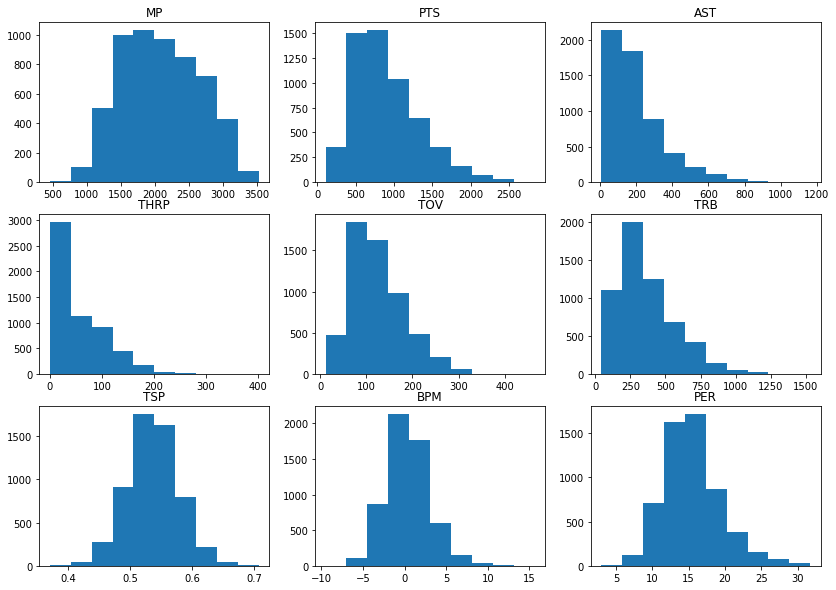

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
fields = ['MP', 'PTS', 'AST', 'THRP', 'TOV', 'TRB', 'TSP', 'BPM', 'PER']
for i in range(3):
    for j in range(3):
        ax[i,j].hist(top_7_by_team[fields[3*i + j]])
        ax[i,j].set_title(fields[3*i + j])


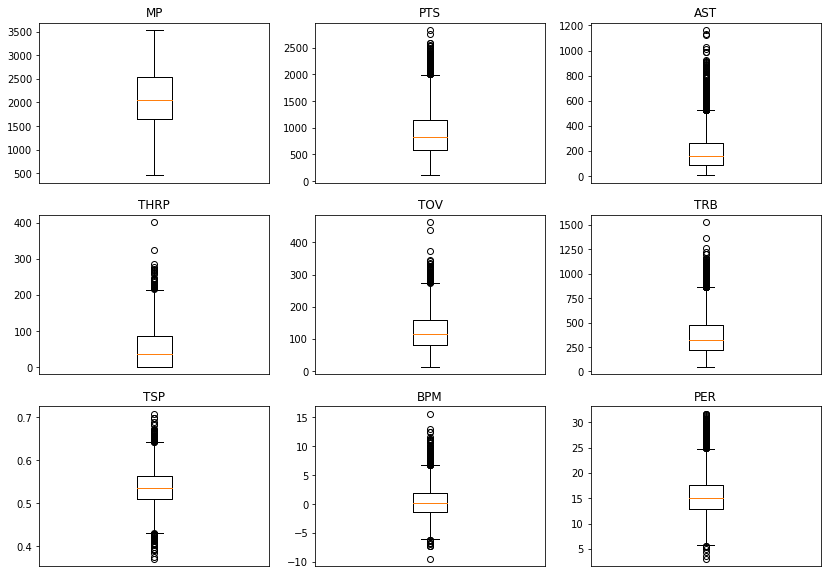

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
fields = ['MP', 'PTS', 'AST', 'THRP', 'TOV','TRB', 'TSP', 'BPM', 'PER']
for i in range(3):
    for j in range(3):
        ax[i,j].boxplot(top_7_by_team[fields[3*i + j]])
        ax[i,j].set_title(fields[3*i + j])
        ax[i,j].tick_params(axis='x', bottom=False, labelbottom=False)

## MP - Minutes Played: Most players in the top 7 in terms of playing time played between 1500 and 3000 minutes in a season. 

## Points (PTS), Assists (AST), Turnovers (TOV), Rebounds (TRB), are all right-skewed. I would expect points and assists to be the most correlated to team success out of these stats.

## TSP is True shooting percentage. It accounts for two point shot percentage, three point shot percentage, and free throw percentage, and represents how "efficiently" a player shoots the ball. This is used to even things out for players that shoot from different ranges. e.g. a tall player may have a high (~60%) field goal percentage from near the hoop (2 points), because it's an easy shot. This is overall less efficient than someone who shoots 45% from three-point land.

## PER (Player Efficiency Rating) and BPM (Box Plus/Minus) are both complex stats aimed at boiling the sum of a player's statistical contributions into one number. They normalize a players stats based on the pace of that players team, and every other player in the league. A PER of 15 or a BPM of 0 is intended to represent an average player. A PER < 10 or BPM < -2 would generally indicate a player who is on the fringe of being on the team. Not surprisingly we don't see too many players below 10 PER in our selection, and that makes sense given that bad players wouldn't be given many minutes. PER > 25 or BPM > 5 signify a player who has a good chance of winning the Most Valuable Player (MVP) award, and PER > 30 or BPM > 10 signify all-time great players. 

## VORP stands for value over replacement player, and converts the BPM rate (BPM/MP) in to a measure of the value a player provides over an average "replacement" player. 

## I expect the three advanced statistics to do a better job of predicting team success than any of the simple statistics. I think VORP will be the best, and slightly better than BPM, because it considers the rate of a players production.

# Lets take look at some of the relationships between the statistics, and note any covariance

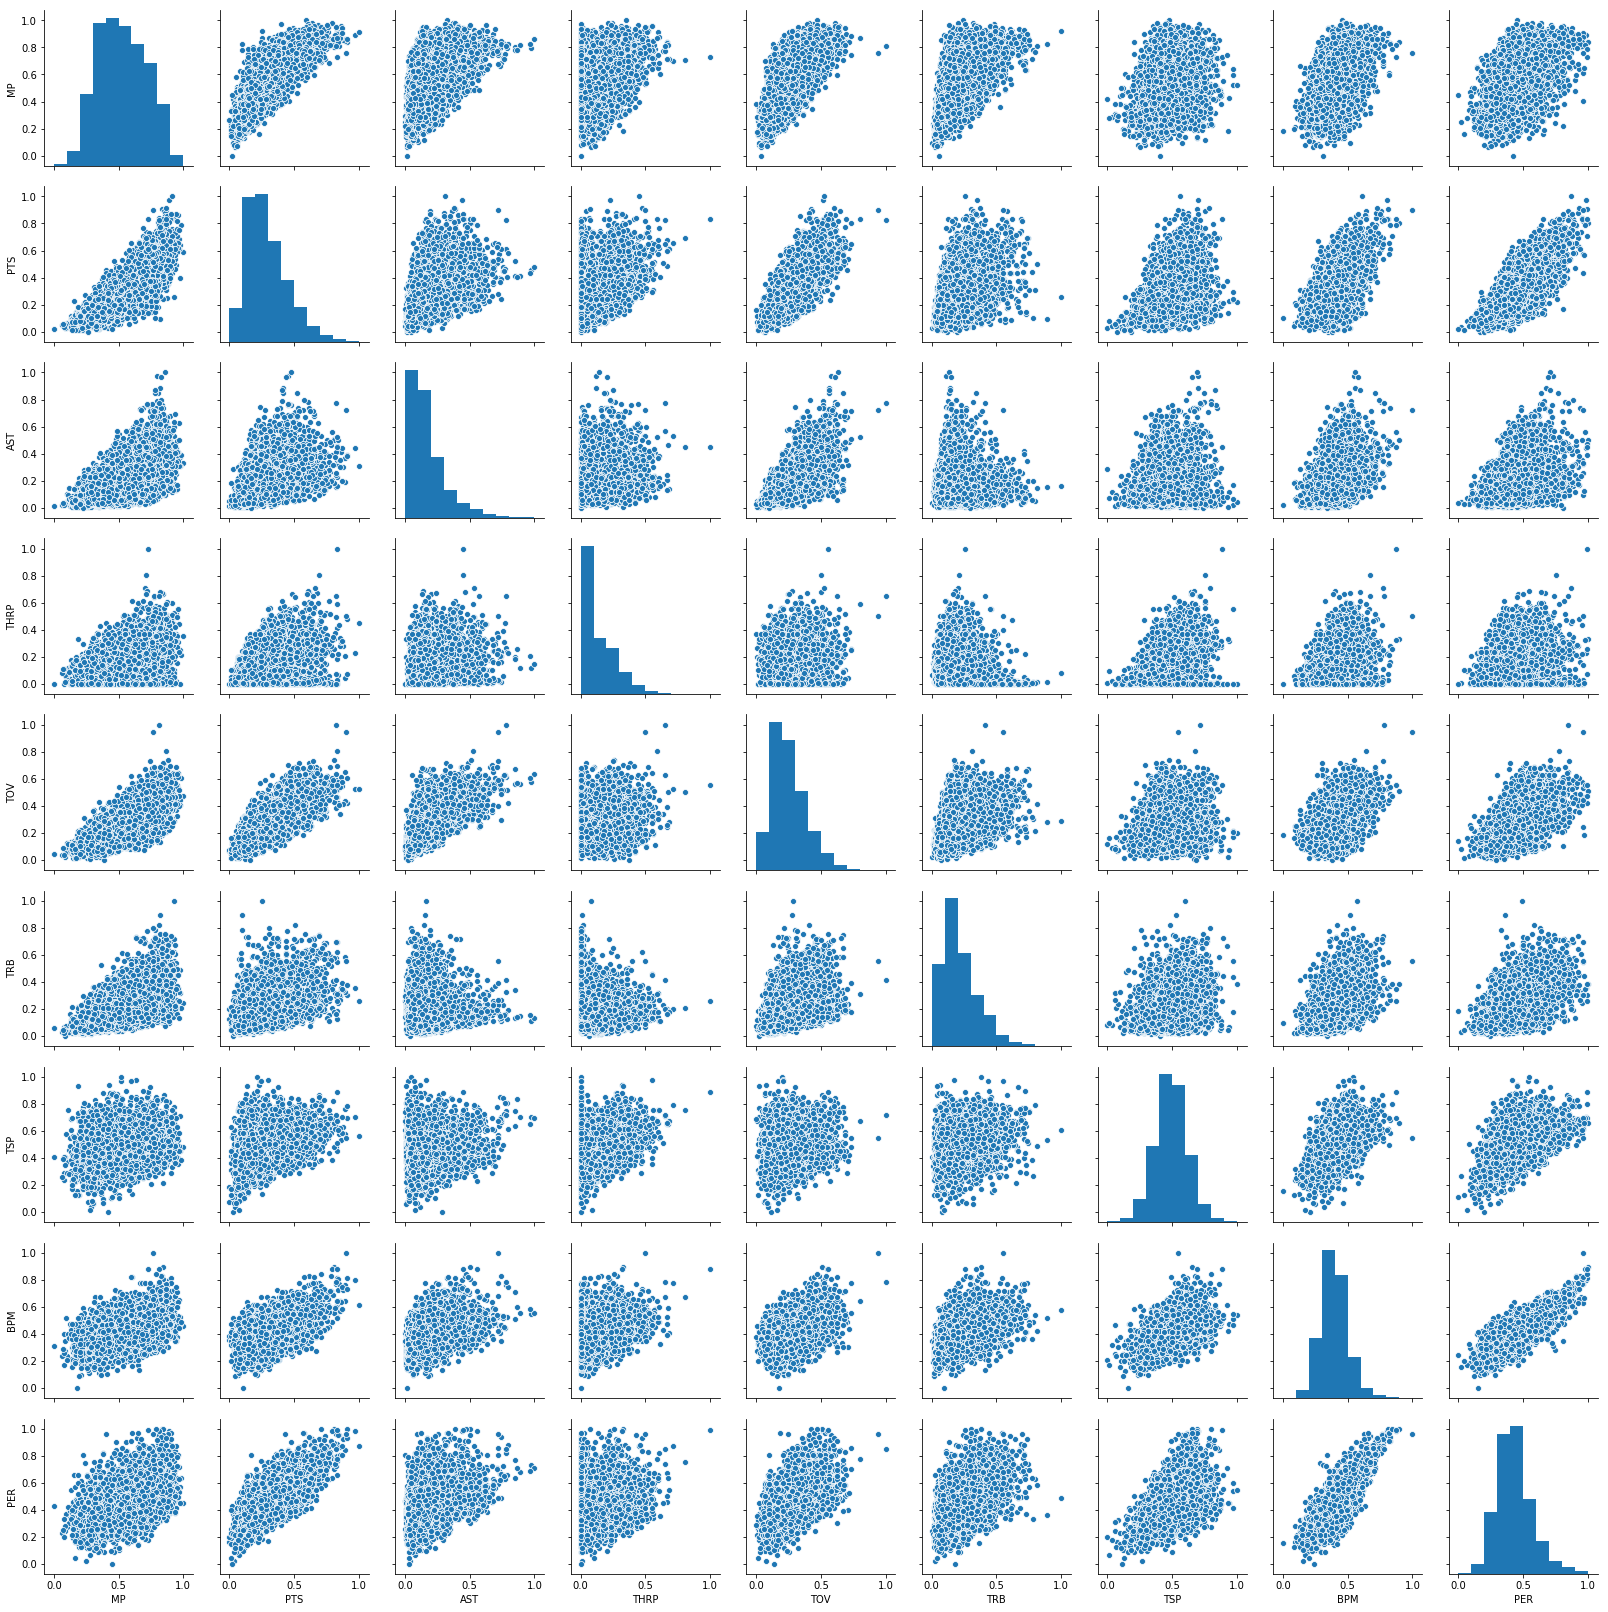

In [26]:
top_7_scaled = top_7_by_team.copy(deep=True)

for attr in fields:
    top_7_scaled[attr] = preprocessing.MinMaxScaler().fit_transform(top_7_scaled[attr].values.reshape(-1,1))

sns.pairplot(top_7_scaled, vars=fields)

## Many of the simple statistics are weakly correlated with minutes played, and with eachother. This makes sense, as players who are on the court more will have more time to score, rebound, assist, etc. 

## BPM and PER correlate fairly strongly, which makes sense as they are both compound statistics intended to measure how good a player is overall. They also seem to correlate with points more than with other simple statistics, which indicates that they place a higher emphasis on points than other stats like rebounds, assists, etc.

## Based on this correlation matrix, I won't drop any columns from further analysis purely based on correlation with another column, although I would anticipate a high degree of colinearity, if we were to have, for instance, points and 2P, in the same model

# Joining Datasets

## Now let's combine our two datasets, by adding the player statistics to their respective team/seasons.
## We're going to create a new column in the team dataset for the specific stat of each player. For example, Player0 and PTS2 will correspond to the name of the best player and points scored by the third best player on a team.

In [27]:
print(win_loss[win_loss.Team == 'Knicks'])

     index  Year    Team Record  Win_Pct
511    873  2017  Knicks  19-26    0.422
512    874  2016  Knicks  32-50    0.390
513    875  2015  Knicks  17-65    0.207
514    876  2014  Knicks  37-45    0.451
515    877  2013  Knicks  54-28    0.659
516    878  2012  Knicks  36-30    0.545
517    879  2011  Knicks  42-40    0.512
518    880  2010  Knicks  29-53    0.354
519    881  2009  Knicks  32-50    0.390
520    882  2008  Knicks  23-59    0.280
521    883  2007  Knicks  33-49    0.402
522    884  2006  Knicks  23-59    0.280
523    885  2005  Knicks  33-49    0.402
524    886  2004  Knicks  39-43    0.476
525    887  2003  Knicks  37-45    0.451
526    888  2002  Knicks  30-52    0.366
527    889  2001  Knicks  48-34    0.585
528    890  2000  Knicks  50-32    0.610
529    891  1999  Knicks  27-23    0.540
530    892  1998  Knicks  43-39    0.524
531    893  1997  Knicks  57-25    0.695
532    894  1996  Knicks  47-35    0.573
533    895  1995  Knicks  55-27    0.671
534    896  1994

In [28]:
# This multilevel index tells us the row of a specific (Team, Year) pair 
# and will save us a lot of time accessing rows in the win_loss table
wl_index = {}
for index, row in win_loss.iterrows():
    wl_index[(row.Year, row.Team)] = index
    
# Add a few more fields that we want to look at    
fields = ['Player', 'Age', 'BLK', 'STL', 'FTP', 'VORP', 'TWOP'] + fields
top_7_grouped = top_7_by_team.groupby(['Year','Tm'])

for (year, team) in top_7_grouped.groups.keys():
    specific_tm = top_7_grouped.get_group((year,team))
    
    for i in range(7):
        player = specific_tm.iloc[i]

        for field in fields:
            win_loss.loc[wl_index[(year,team)], field+str(i)] = player[field]


## Let's verify that it worked

In [29]:
display(win_loss.iloc[np.random.choice(len(win_loss),10)])

,index,Year,Team,Record,Win_Pct,Player0,Age0,BLK0,STL0,FTP0,VORP0,TWOP0,MP0,PTS0,AST0,THRP0,TOV0,TRB0,TSP0,BPM0,PER0,Player1,Age1,BLK1,STL1,FTP1,VORP1,TWOP1,MP1,PTS1,AST1,THRP1,TOV1,TRB1,TSP1,BPM1,PER1,Player2,Age2,BLK2,STL2,FTP2,VORP2,TWOP2,MP2,PTS2,AST2,THRP2,TOV2,TRB2,TSP2,BPM2,PER2,Player3,Age3,BLK3,STL3,FTP3,VORP3,TWOP3,MP3,PTS3,AST3,THRP3,TOV3,TRB3,TSP3,BPM3,PER3,Player4,Age4,BLK4,STL4,FTP4,VORP4,TWOP4,MP4,PTS4,AST4,THRP4,TOV4,TRB4,TSP4,BPM4,PER4,Player5,Age5,BLK5,STL5,FTP5,VORP5,TWOP5,MP5,PTS5,AST5,THRP5,TOV5,TRB5,TSP5,BPM5,PER5,Player6,Age6,BLK6,STL6,FTP6,VORP6,TWOP6,MP6,PTS6,AST6,THRP6,TOV6,TRB6,TSP6,BPM6,PER6
178,317,2005,Mavericks,58-24,0.707,Dirk Nowitzki,26.0,119.0,97.0,0.869,5.9,572.0,3020.0,2032.0,240.0,91.0,176.0,757.0,0.578,5.7,26.1,Jason Terry,27.0,15.0,109.0,0.844,3.0,269.0,2401.0,993.0,429.0,103.0,147.0,188.0,0.606,3.0,18.4,Josh Howard,24.0,49.0,116.0,0.733,2.8,343.0,2446.0,958.0,109.0,34.0,122.0,484.0,0.535,2.5,15.8,Michael Finley,31.0,18.0,48.0,0.831,1.8,271.0,2358.0,1003.0,169.0,116.0,60.0,262.0,0.519,1.0,14.3,Marquis Daniels,24.0,14.0,83.0,0.737,1.0,213.0,1412.0,545.0,128.0,7.0,86.0,216.0,0.484,0.9,14.6,Erick Dampier,29.0,80.0,15.0,0.605,1.1,202.0,1609.0,542.0,51.0,0.0,102.0,501.0,0.580,0.8,15.2,Jerry Stackhouse,30.0,10.0,53.0,0.849,0.4,242.0,1617.0,833.0,127.0,32.0,106.0,183.0,0.525,-1.0,15.9
562,967,1994,Supersonics,63-19,0.768,Shawn Kemp,24.0,166.0,142.0,0.741,5.6,532.0,2597.0,1431.0,207.0,1.0,259.0,851.0,0.593,6.5,22.9,Nate McMillan,29.0,22.0,216.0,0.564,3.4,125.0,1887.0,437.0,387.0,52.0,126.0,283.0,0.520,5.2,15.5,Gary Payton,25.0,19.0,188.0,0.595,3.5,569.0,2881.0,1349.0,494.0,15.0,173.0,269.0,0.526,2.8,17.8,Kendall Gill,25.0,32.0,151.0,0.782,2.1,391.0,2435.0,1111.0,275.0,38.0,143.0,268.0,0.510,1.4,15.6,Detlef Schrempf,31.0,9.0,73.0,0.769,2.2,423.0,2728.0,1212.0,275.0,22.0,173.0,454.0,0.564,1.2,14.9,Sam Perkins,32.0,31.0,67.0,0.801,1.5,242.0,2170.0,999.0,111.0,99.0,103.0,366.0,0.556,0.7,14.9,Michael Cage,32.0,38.0,77.0,0.486,1.2,171.0,1708.0,378.0,45.0,0.0,51.0,444.0,0.545,0.7,11.9
193,332,1990,Mavericks,47-35,0.573,Derek Harper,28.0,26.0,187.0,0.794,4.8,478.0,3007.0,1473.0,609.0,89.0,207.0,244.0,0.567,4.3,19.8,Sam Perkins,28.0,64.0,88.0,0.778,3.3,429.0,2668.0,1206.0,175.0,6.0,148.0,572.0,0.564,2.9,17.3,Rolando Blackman,30.0,21.0,77.0,0.844,1.9,613.0,2934.0,1552.0,289.0,13.0,174.0,280.0,0.552,0.5,17.0,Roy Tarpley,25.0,70.0,79.0,0.756,1.0,314.0,1648.0,758.0,67.0,0.0,117.0,589.0,0.491,0.5,18.0,Adrian Dantley,33.0,7.0,20.0,0.787,0.3,231.0,1300.0,662.0,80.0,0.0,75.0,172.0,0.556,-1.2,15.4,Herb Williams,31.0,106.0,51.0,0.679,0.2,293.0,2199.0,700.0,119.0,2.0,106.0,391.0,0.476,-1.6,10.4,James Donaldson,32.0,47.0,22.0,0.700,0.1,258.0,2265.0,665.0,57.0,0.0,119.0,630.0,0.581,-1.7,12.2
255,457,2012,Warriors,23-43,0.348,Dorell Wright,26.0,26.0,58.0,0.816,1.2,117.0,1650.0,629.0,94.0,105.0,51.0,278.0,0.553,0.9,15.0,Brandon Rush,26.0,58.0,35.0,0.793,1.2,136.0,1717.0,634.0,88.0,99.0,68.0,251.0,0.628,0.7,15.2,David Lee,28.0,22.0,54.0,0.782,1.3,464.0,2121.0,1147.0,162.0,0.0,149.0,545.0,0.549,0.4,19.7,Nate Robinson,27.0,2.0,59.0,0.832,0.6,139.0,1192.0,570.0,231.0,66.0,75.0,100.0,0.534,0.0,18.0,Monta Ellis,26.0,12.0,56.0,0.812,0.6,255.0,1365.0,811.0,223.0,50.0,123.0,127.0,0.516,-0.3,18.6,Dominic McGuire,26.0,36.0,44.0,0.736,0.4,94.0,1127.0,227.0,110.0,0.0,56.0,246.0,0.486,-0.4,11.8,Klay Thompson,21.0,20.0,49.0,0.868,0.1,207.0,1608.0,826.0,133.0,111.0,103.0,161.0,0.545,-1.9,14.9
615,1042,1997,76ers,22-60,0.268,Allen Iverson,21.0,24.0,157.0,0.702,2.7,470.0,3045.0,1787.0,567.0,155.0,337.0,312.0,0.513,1.5,18.0,Derrick Coleman,29.0,75.0,50.0,0.745,1.1,332.0,2102.0,1032.0,193.0,32.0,184.0,573.0,0.518,0.1,17.3,Mark Davis,23.0,31.0,85.0,0.673,0.7,227.0,1705.0,639.0,135.0,24.0,118.0,323.0,0.525,-0.4,13.7,Clarence Weatherspoon,26.0,86.0,74.0,0.738,1.0,397.0,2949.0,1003.0,140.0,1.0,137.0,679.0,0.537,-0.7,14.2,Michael Cage,35.0,42.0,48.0,0.463,0.2,66.0,1247.0,151.0,43.0,0.0,17.0,320.0,0.475,-1.3,10.3,Scott Williams,28.0,41.0,44.0,0

### This was a complex dataset to generate, so let's save it to a CSV file

In [30]:
win_loss.to_csv('combined_stats.csv')

# Let's start our regression analysis by seeing which simple statistics contribute the most to win percentage

In [31]:
model_age = smf.ols(formula='Win_Pct~Age0+Age1+Age2+Age3+Age4+Age5+Age6', data=win_loss).fit() 
model_mp = smf.ols(formula='Win_Pct~MP0+MP1+MP2+MP3+MP4+MP5+MP6', data=win_loss).fit()
model_pts = smf.ols(formula='Win_Pct~PTS0+PTS1+PTS2+PTS3+PTS4+PTS5+PTS6', data=win_loss).fit()
model_ast = smf.ols(formula='Win_Pct~AST0+AST1+AST2+AST3+AST4+AST5+AST6', data=win_loss).fit()
model_2p = smf.ols(formula='Win_Pct~TWOP0+TWOP1+TWOP2+TWOP3+TWOP4+TWOP5+TWOP6', data=win_loss).fit()
model_3p = smf.ols(formula='Win_Pct~THRP0+THRP1+THRP2+THRP3+THRP4+THRP5+THRP6', data=win_loss).fit()
model_ftp = smf.ols(formula='Win_Pct~FTP0+FTP1+FTP2+FTP3+FTP4+FTP5+FTP6', data=win_loss).fit()
model_reb = smf.ols(formula='Win_Pct~TRB0+TRB1+TRB2+TRB3+TRB4+TRB5+TRB6', data=win_loss).fit()
model_blk = smf.ols(formula='Win_Pct~BLK0+BLK1+BLK2+BLK3+BLK4+BLK5+BLK6', data=win_loss).fit()
model_stl = smf.ols(formula='Win_Pct~STL0+STL1+STL2+STL3+STL4+STL5+STL6', data=win_loss).fit()

print("Age Model R_Sqared:", model_age.rsquared_adj)
print("Minutes Played Model R_Sqared:", model_mp.rsquared_adj)
print("Points Model R_Sqared:", model_pts.rsquared_adj)
print("Assists Model R_Sqared:", model_ast.rsquared_adj)
print("2 Point Model R_Sqared:", model_2p.rsquared_adj)
print("3 Point Model R_Sqared:", model_3p.rsquared_adj)
print("Free Throw % Model R_Sqared:", model_ftp.rsquared_adj)
print("Rebounds Model R_Sqared:", model_reb.rsquared_adj)
print("Blocks Model R_Sqared:", model_blk.rsquared_adj)
print("Steals Model R_Sqared:", model_stl.rsquared_adj)

Age Model R_Sqared: 0.25074619658017105
Minutes Played Model R_Sqared: 0.09585845417768735
Points Model R_Sqared: 0.18287172353238013
Assists Model R_Sqared: 0.19161349786385728
2 Point Model R_Sqared: 0.09389595478220314
3 Point Model R_Sqared: 0.05503419695167466
Free Throw % Model R_Sqared: 0.024773323910900036
Rebounds Model R_Sqared: 0.1375740838648869
Blocks Model R_Sqared: 0.07656432277777148
Steals Model R_Sqared: 0.0820435600149989


## Surprisingly, the age of a team's starting 5 is more strongly correlated with their win percentage than any other simple stat, even the number of points they score. This could be interpreted as experience in the NBA being a good marker of success. 
## Points and assists are both more strongly correlated with winning than other simple stats. They both give an r squared of ~.16. This makes some sense, given the fact that most points come from an assist. 
## Still, none of these simple stats show much promise for predicting win rate for a team on their own. Let's look at some complex stats and see if they can help us.

In [32]:
model_tsp = smf.ols(formula='Win_Pct~TSP0+TSP1+TSP2+TSP3+TSP4+TSP5+TSP6', data=win_loss).fit() 
model_per = smf.ols(formula='Win_Pct~PER0+PER1+PER2+PER3+PER4+PER5+PER6', data=win_loss).fit()
model_bpm = smf.ols(formula='Win_Pct~BPM0+BPM1+BPM2+BPM3+BPM4+BPM5+BPM6', data=win_loss).fit()
model_vorp = smf.ols(formula='Win_Pct~VORP0+VORP1+VORP2+VORP3+VORP4+VORP5+VORP6', data=win_loss).fit()

print("True Shooting % Model R_Sqared:", model_tsp.rsquared_adj)
print("Player Efficiency Rating R_Sqared:", model_per.rsquared_adj)
print("BPM Model:", model_bpm.rsquared_adj)
print("VORP Model:", model_vorp.rsquared_adj)

True Shooting % Model R_Sqared: 0.335654802803128
Player Efficiency Rating R_Sqared: 0.5779960967905862
BPM Model: 0.876759836670675
VORP Model: 0.8638423391546602


## Now we're getting somewhere, all three of these complex stats have higher r sqared values than any of the simple statistics. For PER, BPM, and VORP that makes a lot of sense, because it factors in ALL of the simple statistics above, save for age. I was incorrect about VORP being more predictive than BPM. 

## But before we turn our backs on simple stats, let's see if we can put them together in a way that rivals the ability of BPM to predict wins.

In [33]:
model_combined = model_mp = smf.ols(formula='''Win_Pct~PTS0+PTS1+PTS2+PTS3+PTS4+PTS5+PTS6
                                                    +AST0+AST1+AST2+AST3+AST4+AST5+AST6
                                                    +FTP0+FTP1+FTP2+FTP3+FTP4+FTP5+FTP6
                                                    +TRB0+TRB1+TRB2+TRB3+TRB4+TRB5+TRB6
                                                    +BLK0+BLK1+BLK2+BLK3+BLK4+BLK5+BLK6
                                                    +STL0+STL1+STL2+STL3+STL4+STL5+STL6
                                                    +TWOP0+TWOP1+TWOP2+TWOP3+TWOP4+TWOP5+TWOP6
                                                    +THRP0+THRP1+THRP2+THRP3+THRP4+THRP5+THRP6
                                                    ''', data=win_loss).fit()
print(model_combined.rsquared_adj)

0.3123936840774001


## This model has a r sqared value that's greater than the sum of its parts, but it is nowhere near as good as the BPM model.

In [34]:
print(model_bpm.summary())

                            OLS Regression Results                            
Dep. Variable:                Win_Pct   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     826.3
Date:                Sat, 14 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:31:40   Log-Likelihood:                 1202.3
No. Observations:                 813   AIC:                            -2389.
Df Residuals:                     805   BIC:                            -2351.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4056      0.006     62.932      0.0

# Analysis of model

### From the summary above, we see that the BPM stats for all 7 players are very significant in the model. The condition number is relatively low which indicates that the BPM for the top 7 players on a team aren't very colinear. Let's check this with a pairplot that shows the relationship between BPM for players on the same team.

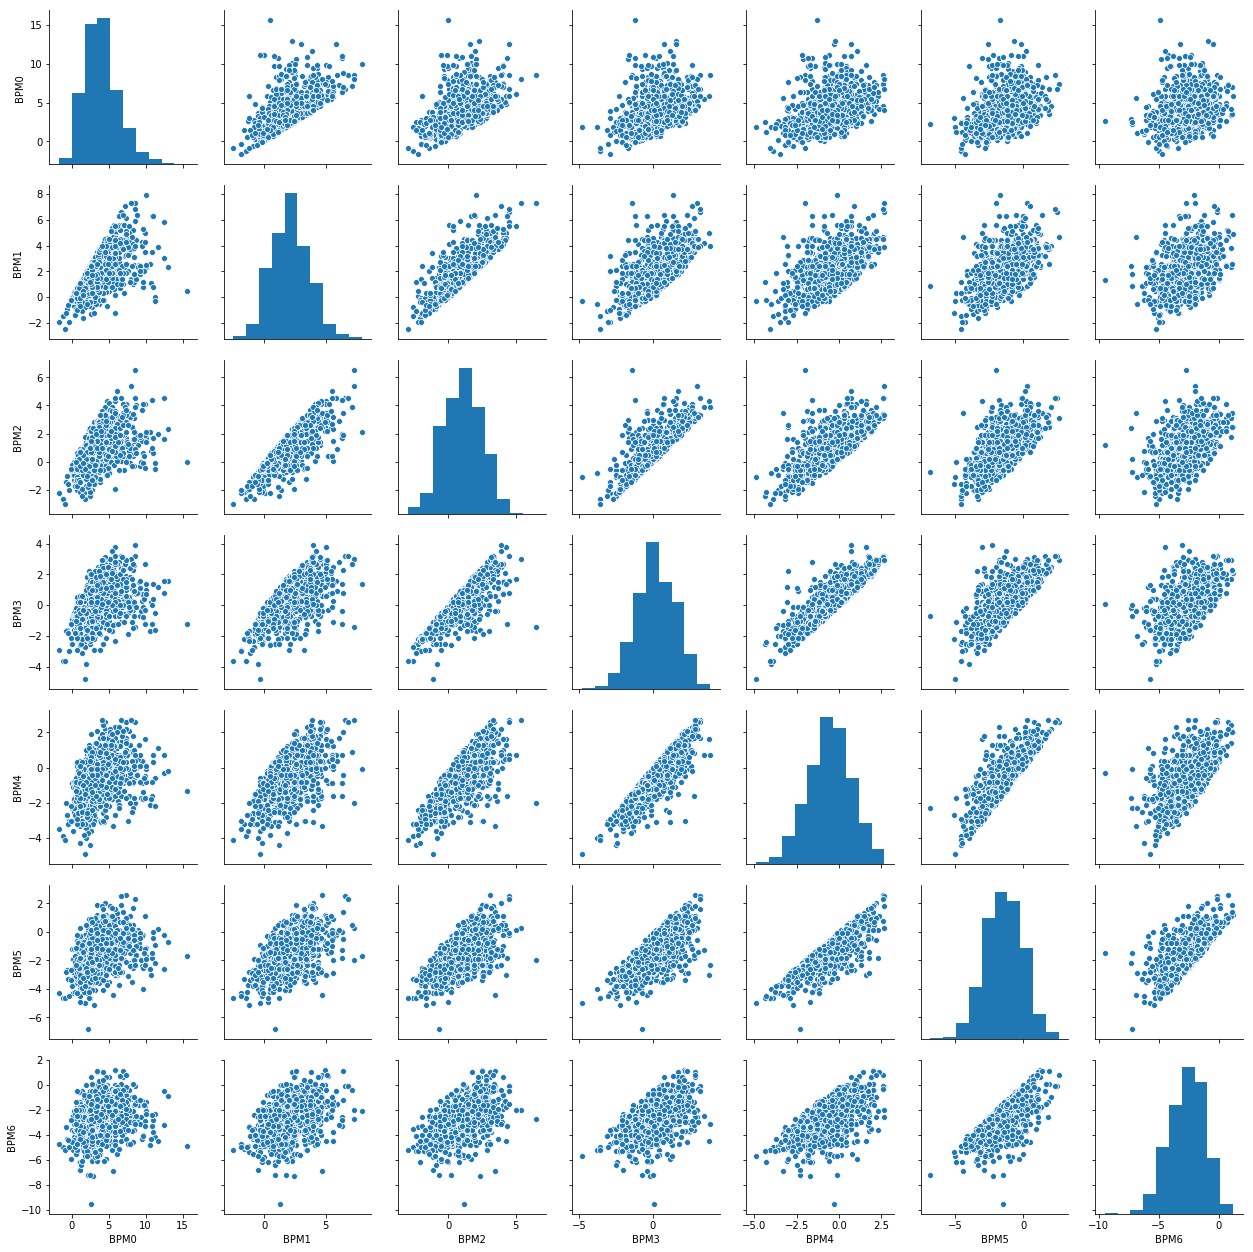

In [35]:
sns.pairplot(win_loss, vars=["BPM" + str(i) for i in range(7)])

### This lack of colinearity between the BPM's for the players on a team make it a good metric for the type of modeling that we're doing here.

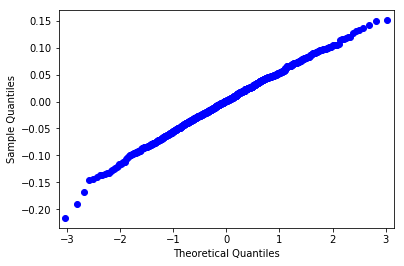

In [36]:
sm.qqplot(model_bpm.resid);

## As our QQ plot appears linear, our choice of a linear model seems to be a good one.

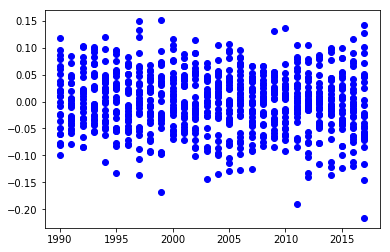

In [37]:
plt.plot(win_loss.Year, model_bpm.resid, 'bo');

## When we plot the residual values against the year, we can see that it is fairly uniformly distributed, meaning that our model seems to be a good one for the timeframe of 1990 - 2017, and doesn't favor any time period over another. 

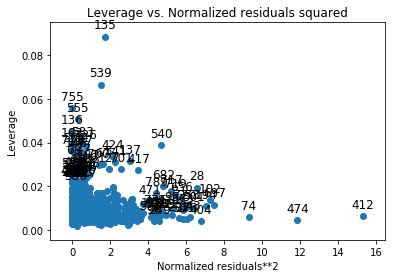

In [38]:
sm.graphics.plot_leverage_resid2(model_bpm);

## The leverage vs. residual plot doesn't show any noticeably high leverage, high residual points. But let's check a few of these points anyways.

In [39]:
yhat = model_bpm.predict(win_loss)
print("Predicted win percentage:", yhat[412])
print(win_loss.iloc[412][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.5339837218114312
Team                   Heat
Year                   2017
Record                14-30
Win_Pct               0.318
Player0        Goran Dragic
BPM0                    2.7
Player1       James Johnson
BPM1                    2.7
Player2       Tyler Johnson
BPM2                    1.5
Player3     Josh Richardson
BPM3                    0.2
Player4     Wayne Ellington
BPM4                   -0.2
Player5     Rodney McGruder
BPM5                   -0.4
Player6    Hassan Whiteside
BPM6                   -0.5
Name: 412, dtype: object


In [40]:
print("Predicted win percentage:", yhat[474])
print(win_loss.iloc[474][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.39700075738185603
Team           Timberwolves
Year                   2011
Record                17-65
Win_Pct               0.207
Player0          Kevin Love
BPM0                    3.7
Player1    Anthony Tolliver
BPM1                    0.4
Player2        Luke Ridnour
BPM2                   -0.3
Player3       Darko Milicic
BPM3                   -0.8
Player4      Wesley Johnson
BPM4                   -1.6
Player5        Corey Brewer
BPM5                   -1.9
Player6     Michael Beasley
BPM6                   -2.4
Name: 474, dtype: object


## Both of the largest residual points were over predictions of about 20%. This isn't bad at all. There aren't any examples of the model predicting really good teams to be really bad, or vice versa. 

## BPM and other advanced metrics tend to favor offense, as offensive contributions (namely points) are much easier to quantify statistically than defensive contributions. For example, an excellent defender may reduce their opponent's FG% significantly, but this is not reflected in the box score of a game. 

## Because of this, I suspect that some of the residual is from teams that were good on offense, but poor defensively. 
## A quick google search for the 2011 Timberwolves led me to one journalists description of the team's defense: "There's nowhere near an amount of words to describe the defensive effort, skill and intensity that was nonexistant on this team. Absolutely absymal, utterly ugly and just horrific. An embarrassment on this end of the floor." Ouch.

## I'm happy with the model's prediction capabilities at the fringes as well. It comes pretty close to predicting the win percentages for the two winningest teams in history, which were both stacked with high BPM players.

In [41]:
print("Predicted win percentage:", yhat[131])
print(win_loss.iloc[131][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.9303609858279402
Team                Bulls
Year                 1996
Record              72-10
Win_Pct             0.878
Player0    Michael Jordan
BPM0                  8.6
Player1    Scottie Pippen
BPM1                  6.8
Player2        Toni Kukoc
BPM2                  4.5
Player3     Dennis Rodman
BPM3                  3.2
Player4        Ron Harper
BPM4                  2.6
Player5        Steve Kerr
BPM5                  2.3
Player6       Luc Longley
BPM6                 -0.1
Name: 131, dtype: object


In [42]:
print("Predicted win percentage:", yhat[251])
print(win_loss.iloc[251][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.9038439264517109
Team               Warriors
Year                   2016
Record                 73-9
Win_Pct                0.89
Player0       Stephen Curry
BPM0                   12.5
Player1      Draymond Green
BPM1                    5.8
Player2        Andrew Bogut
BPM2                    4.5
Player3      Andre Iguodala
BPM3                    1.6
Player4       Klay Thompson
BPM4                    0.7
Player5     Harrison Barnes
BPM5                   -0.2
Player6    Shaun Livingston
BPM6                   -0.5
Name: 251, dtype: object


## Likewise for really bad teams

In [43]:
print("Predicted win percentage:", yhat[89])
print(win_loss.iloc[89][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.0615903892679478
Team                Bobcats
Year                   2012
Record               Jul-59
Win_Pct               0.106
Player0        Kemba Walker
BPM0                   -1.2
Player1       Derrick Brown
BPM1                   -1.5
Player2    Gerald Henderson
BPM2                   -2.6
Player3       D.J. Augustin
BPM3                   -3.6
Player4     Bismack Biyombo
BPM4                   -3.9
Player5          D.J. White
BPM5                   -4.6
Player6       Byron Mullens
BPM6                     -5
Name: 89, dtype: object


## The PER model is a lot more conservative for really good/bad teams.

In [44]:
yhat1 = model_per.predict(win_loss)
print("Predicted win percentage:", yhat1[251])
print(win_loss.iloc[251][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'PER0', 'Player1', 'PER1', 'Player2', 'PER2', 'Player3', 'PER3', 'Player4', 'PER4', 'Player5', 'PER5', 'Player6', 'PER6']])

Predicted win percentage: 0.7591672167330578
Team               Warriors
Year                   2016
Record                 73-9
Win_Pct                0.89
Player0       Stephen Curry
PER0                   31.5
Player1      Draymond Green
PER1                   19.3
Player2        Andrew Bogut
PER2                   15.9
Player3      Andre Iguodala
PER3                   12.2
Player4       Klay Thompson
PER4                   18.6
Player5     Harrison Barnes
PER5                   12.3
Player6    Shaun Livingston
PER6                   13.8
Name: 251, dtype: object


In [45]:
yhat1 = model_per.predict(win_loss)
print("Predicted win percentage:", yhat1[131])
print(win_loss.iloc[131][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'PER0', 'Player1', 'PER1', 'Player2', 'PER2', 'Player3', 'PER3', 'Player4', 'PER4', 'Player5', 'PER5', 'Player6', 'PER6']])

Predicted win percentage: 0.8005717529951831
Team                Bulls
Year                 1996
Record              72-10
Win_Pct             0.878
Player0    Michael Jordan
PER0                 29.4
Player1    Scottie Pippen
PER1                   21
Player2        Toni Kukoc
PER2                 20.4
Player3     Dennis Rodman
PER3                 13.6
Player4        Ron Harper
PER4                 14.4
Player5        Steve Kerr
PER5                 15.2
Player6       Luc Longley
PER6                 11.9
Name: 131, dtype: object


In [46]:
yhat1 = model_per.predict(win_loss)
print("Predicted win percentage:", yhat1[89])
print(win_loss.iloc[89][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'PER0', 'Player1', 'PER1', 'Player2', 'PER2', 'Player3', 'PER3', 'Player4', 'PER4', 'Player5', 'PER5', 'Player6', 'PER6']])

Predicted win percentage: 0.26058732023663367
Team                Bobcats
Year                   2012
Record               Jul-59
Win_Pct               0.106
Player0        Kemba Walker
PER0                   14.9
Player1       Derrick Brown
PER1                   14.7
Player2    Gerald Henderson
PER2                     14
Player3       D.J. Augustin
PER3                   14.1
Player4     Bismack Biyombo
PER4                   10.6
Player5          D.J. White
PER5                   12.4
Player6       Byron Mullens
PER6                     13
Name: 89, dtype: object


## From this analysis, PER is certainly less effective at predicticting team success from individual stats. I think this is based on it's poor range compared to BPM. For example: by BPM, Steph Curry was much better in 2016 (12.5 BPM)  than Michael Jordan was in 1996 (8.6 BPM), but the two are hardly separated at all in terms of PER (31.5 vs 29.4). Based on this I would argue that BPM should be favored over PER in general for evaluating player contributions

# K-Nearest Neighbors Modeling

## Linear regression modeling is particularly useful for inference. In our case, we came to the conclusion that team success is dependent on BPM more than any other individual statistic. Let's see if we can create a K-Nearest neighbors model based on BPM that is more accurate than our linear regression model at predicting team success.

In [47]:
# Scale and separate into X (BPM) and y (Win_Pct)
BPM_scaled = preprocessing.scale(win_loss[['BPM0', 'BPM1', 'BPM2', 'BPM3', 'BPM4','BPM5', 'BPM6']])
win_pct_scaled = preprocessing.scale(win_loss[['Win_Pct']])

# Split randomly into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(BPM_scaled, win_pct_scaled, test_size=0.5)

In [48]:
neigh = KNeighborsRegressor(n_neighbors=1)

for k in range (1,6):
    neigh = KNeighborsRegressor(n_neighbors=k)
    print(k, "nearest neighbors score:", neigh.fit(X_train, y_train).score(X_test, y_test))

1 nearest neighbors score: 0.7569672179892162
2 nearest neighbors score: 0.7955820019599282
3 nearest neighbors score: 0.8225412830097385
4 nearest neighbors score: 0.8411580108621354
5 nearest neighbors score: 0.8457012704976586


## Our KNN model levels off at an $R^2$ of about .84, so it is actually less accurate than linear regression for this problem. I would guess that this is due to team success being related to the total BPM for the 7 players who play the most, which the linear model takes into account.

# =============================================================

# Conclusions:
## 1. Advanced player statistics provide the ability to accurately predict an NBA team's winning percentage
## 2. Linear regression using Box Plus/Minus (BPM) can predict a team's winning percentage with an $R^2$ of 0.87, which is significantly more accurate than models using any other box score statistic, including PER. For this reason it should be considered the most important of these statistics, especially as it relates to team success.
## 3. A BPM linear regression model for the top 7 players by playing time doesn't favor any era of the NBA over another.

# Future Directions:
## Use logistic regression or KNN classification to predict playoff/championship teams from BPM or other individual statistics.
## Create an accurate model for predicting win percentage based on team statistics, like fast-break points, team rebound percentage, etc.
## Apply this type of analysis to other sports like Hockey or American Football to determine if individual statistics are as important in these sports.